In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import urllib.request
from tqdm import tqdm

%matplotlib inline

# Task 1

## Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [5]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug12.dat'

In [37]:
opt_vals={ 'nug12': 578, 'nug14': 1014, 'nug15': 1150, 'nug17': 1732}

## Reading input data

In [6]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [21]:
def qap_objective_function(p, A=A,B=B):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [22]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [9]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

58.51712989807129
606.0 [11  8  2  1  7  6  0  9  3 10  5  4]


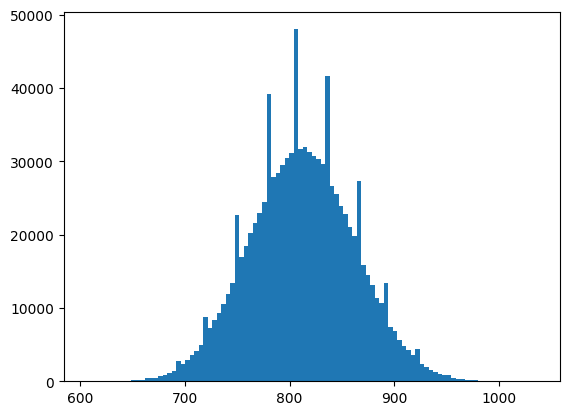

811.98907 49.756882906137704


In [10]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [11]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

## Subpoints a and b

In [19]:
def read_nug(n=12):
    qap_instance_file = open(f'qap/nug{n}.dat')

    line = qap_instance_file.readline()
    n = int(line)

    A = np.empty((n, n))
    qap_instance_file.readline()
    
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.split()))

    B = np.empty((n, n))
    qap_instance_file.readline()
    
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.split()))
        
    qap_instance_file.close()
    
    return A , B

In [32]:
T = 500000
radius = 1
alpha = 0.5
N = [12,14,15,17]
runs = 3
costs = np.zeros((len(N), runs))
all_costs = []

for j, n in enumerate(N):
    print(f'nug{n}')
    An , Bn = read_nug(n)
    
    all_costs.append([])
    
    for r in range(runs):
        all_costs[j].append([])
        p = np.random.permutation(n)
        p_cost = qap_objective_function(p, An, Bn)
        
        for i in tqdm(range(T)):
            q = random_neighbor(p, radius)
            q_cost = qap_objective_function(q, An, Bn)
            
            if(q_cost < p_cost):
                p, p_cost = q, q_cost
            elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * i/T)):
                p, p_cost = q, q_cost
                
            all_costs[j][r].append(p_cost)

        costs[j, r] = p_cost

nug12


100%|██████████| 500000/500000 [00:54<00:00, 9250.85it/s] 


nug14


100%|██████████| 500000/500000 [00:58<00:00, 8497.47it/s] 


nug15


100%|██████████| 500000/500000 [01:02<00:00, 8059.64it/s] 


nug17


100%|██████████| 500000/500000 [01:10<00:00, 7061.20it/s]


In [33]:
costs

array([[ 578.,  578.,  590.],
       [1016., 1016., 1014.],
       [1152., 1150., 1150.],
       [1748., 1746., 1740.]])

In [34]:
print(f"optimal values:  nug12:578, nug14:1014, nug15:1150, nug17:1732")
for i, n in enumerate(N):
    print(f'N={n} mean={costs[i].mean()} std={costs[i].std()}, min={costs[i].min()}')

optimal values:  nug12:578, nug14:1014, nug15:1150, nug17:1732
N=12 mean=582.0 std=5.656854249492381, min=578.0
N=14 mean=1015.3333333333334 std=0.9428090415820634, min=1014.0
N=15 mean=1150.6666666666667 std=0.9428090415820634, min=1150.0
N=17 mean=1744.6666666666667 std=3.39934634239519, min=1740.0


In [35]:
for c, m in zip(costs, np.min(costs, axis=1)):
    print(f'Minimum {m} reached {np.sum(c==m)/c.size} times')

Minimum 578.0 reached 0.6666666666666666 times
Minimum 1014.0 reached 0.3333333333333333 times
Minimum 1150.0 reached 0.6666666666666666 times
Minimum 1740.0 reached 0.3333333333333333 times


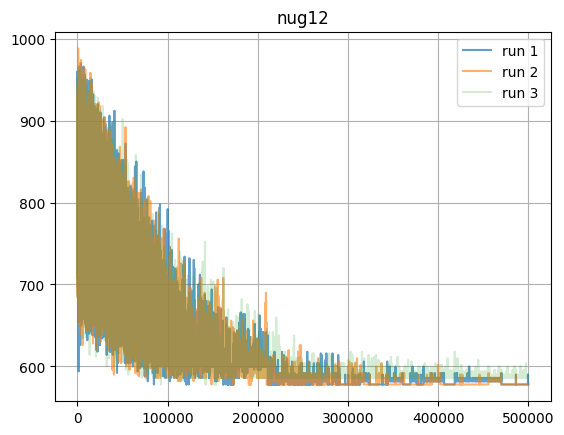

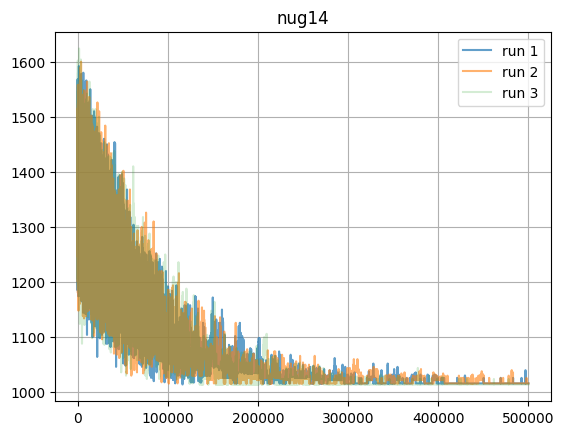

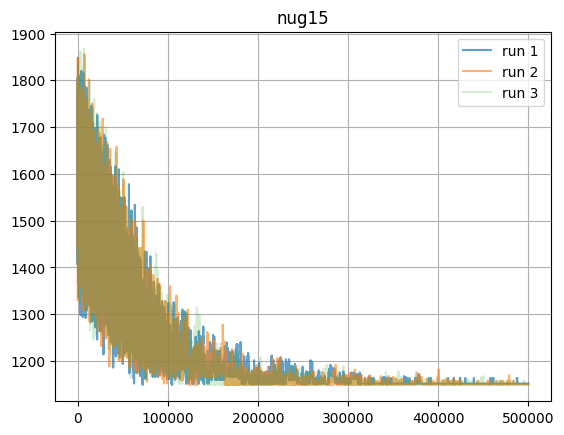

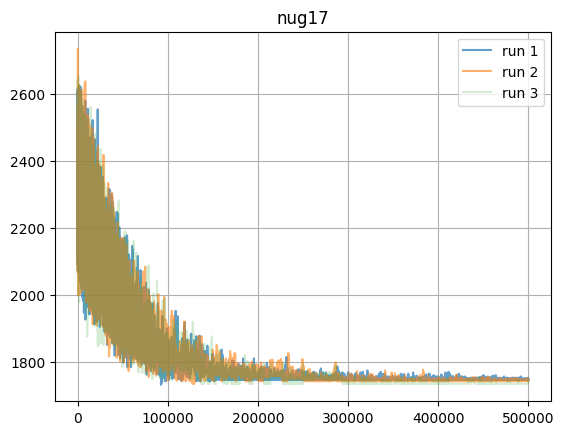

In [57]:
for i, n in enumerate(N):
    plt.figure()
    plt.title(f'nug{n}')
    plt.grid()
    plt.plot(all_costs[i][0], alpha=0.7, label='run 1', linestyle='-')
    plt.plot(all_costs[i][1], alpha=0.6, label='run 2', linestyle='-')
    plt.plot(all_costs[i][2], alpha=0.2, label='run 3', linestyle='-')
    # plt.plot(np.average(all_costs[i][0], axis=0), label='run 1')
    # plt.plot(np.average(all_costs[i][1], axis=0), label='run 2')
    # plt.plot(np.average(all_costs[i][2], axis=0), label='run 3')
    plt.legend()
    plt.show()

## Subpoint c

In [53]:
# nug12
T = 5000
radius = 1
alpha = 1.0
n = 12
An, Bn = read_nug(n)

params = [(1,1), (0.1, 2), (10,1), (0.5, 3)]

successes = np.zeros((T, 4))
acceptable_losses = np.zeros((T, 4))

costs = np.zeros((T, len(params)))

for c in range(len(params)):
    alpha, radius = params[c]
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, An, Bn)
    
    for t in tqdm(range(T)):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            
            successes[t, c] = successes[t-1, c] + 1
            acceptable_losses[t, c] = acceptable_losses[t-1, c]
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            
            successes[t, c] = successes[t-1, c]
            acceptable_losses[t, c] = acceptable_losses[t-1, c] + 1
        else:
            successes[t, c] = successes[t-1, c]
            acceptable_losses[t, c] = acceptable_losses[t-1, c]

        costs[t, c] = p_cost

100%|██████████| 5000/5000 [00:00<00:00, 6236.74it/s]


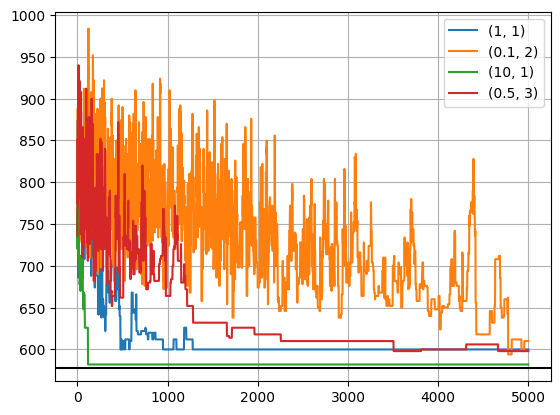

In [54]:
plt.figure()

plt.grid()
plt.plot(costs)
plt.axhline(y=opt_vals['nug12'], color='black', linestyle='-')
plt.legend(params)
plt.show()

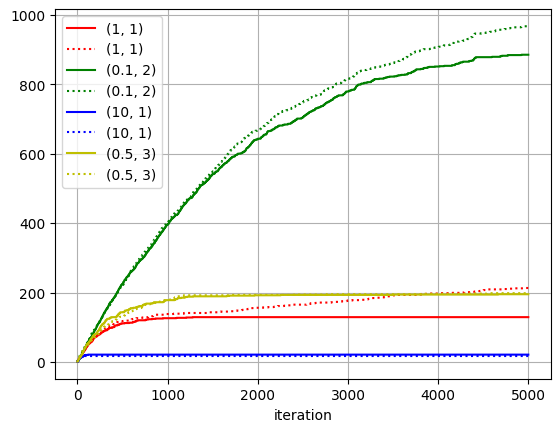

In [60]:
plt.figure()
plt.grid()

colors=['r', 'g', 'b', 'y']

for c in range(len(params)):
    plt.plot(np.arange(T), successes[:, c], color=colors[c], linestyle='solid', label=params[c])
    plt.plot(np.arange(T), acceptable_losses[:, c], color=colors[c], linestyle='dotted', label=params[c])
    
plt.legend()
plt.xlabel('iteration')
plt.show()

# Task 2

## PBIL implementation

In [224]:
from numpy.random import default_rng
rng = default_rng()

def binary_random(p):
    if rng.uniform() < p:
        return 1
    else:
        return 0

def random_individual(p, d):
    v = []
    for i in range(d):
        v.append(binary_random(p[i]))
    
    return v

def random_population(p, N, d):
    P = []
    for _ in range(N):
        P.append(random_individual(p, d))

    return np.array(P)

def population_evaluation(target, population, d, N, score_func, k=None):
    target_score = score_func(target)
    scores = np.array(list(map(score_func, population)))

    # score = 0

    # for i in range(N):
    #     diff = np.abs(target_score - scores[i])
    #     score += (d - diff) / d

    # return score / N
    correct = 0

    for score in scores:
        if score == target_score:
            correct += 1

    return correct / N

def termination_condition(score):
    return score >= 0.80

def get_best_individual(target, population, N, score_func, k=None):
    target_score = score_func(target)
    scores = np.array(list(map(score_func, population)))
    min = np.inf
    best = None

    for i in range(N):
        if scores[i] == target_score:
            return population[i]
        diff = np.abs(target_score - scores[i])
        if diff < min:
            min = diff
            best = population[i]
    
    return best

def PBIL(target, d, N, lr, mutation_ppb, mutation_dist, score_func, k=None):
    """
    d - chromosome size
    N - population size
    """
    p = np.full(d, 0.5, dtype=np.float32)
    population = random_population(p, N, d)

    population_score = population_evaluation(target, population, d, N, score_func, k)
    # print('population_score', population_score)
    steps = 0
    while not termination_condition(population_score):
        # print('population_score', population_score)
        best_individual = get_best_individual(target, population, N, score_func, k)
        # print('best_individual', best_individual)

        for i in range(d):
            p[i] = p[i]*(1 - lr) + best_individual[i]*lr

        for i in range(d):
            if rng.uniform() < mutation_ppb:
                p[i] = p[i]*(1 - mutation_dist) + binary_random(0.5)*mutation_dist

        population = random_population(p, N, d)
        population_score = population_evaluation(target, population, d, N, score_func, k)
        steps += 1
    # print('population_score', population_score)

    return get_best_individual(target, population, N, score_func), population_score, steps

In [225]:
def OneMax(p):
    return p.sum()

def DeceptiveOneMax(p):
    if np.all((p == 0)):
        return p.shape[0] + 1
    return p.sum()

def KDeceptiveOneMax(p, k=2):
    sum = 0
    i = 0

    while i < p.shape[0]:
        sum += DeceptiveOneMax(p[i:i+k])
        i = i+k

    return sum

In [221]:
from itertools import product
from time import time

N_l = [3, 4, 5, 6, 8]
lr_l = [0.01, 0.05, 0.1, 0.5]
mutation_ppb_l = [0.01, 0.05, 0.1, 0.5]
mutation_dist_l = [0.01, 0.05, 0.1, 0.5]
score_func_l = [OneMax, DeceptiveOneMax, KDeceptiveOneMax]
k_l = [2, 4, 6]

ones = 8
zeros = 4
target = np.array([1] * ones + [0] * zeros)
np.random.shuffle(target)
target
results = []

start = time()

for N, lr, mutation_ppb, mutation_dist, score_func in product(N_l, lr_l, mutation_ppb_l, mutation_dist_l, score_func_l):
    if score_func.__name__ == 'KDeceptiveOneMax':
        for k in k_l:
            res, population_score, steps = PBIL(target, target.shape[0], N, lr, mutation_ppb, mutation_dist, score_func, k)
            results.append({
                'N': N,
                'lr': lr,
                'mutation_ppb': mutation_ppb,
                'mutation_dist': mutation_dist,
                'score_func': score_func.__name__,
                'k': k,
                'population_score': population_score,
                'steps': steps,
                'result': res,

            })
    else:
        res, population_score, steps = PBIL(target, target.shape[0], N, lr, mutation_ppb, mutation_dist, score_func)
        results.append({
            'N': N,
            'lr': lr,
            'mutation_ppb': mutation_ppb,
            'mutation_dist': mutation_dist,
            'score_func': score_func.__name__,
            'k': None,
            'population_score': population_score,
            'steps': steps,
            'result': res,
        })

end = time()
print("It took", end - start)

It took 9460.51943731308


In [227]:
df = pd.DataFrame(results)
df

,N,lr,mutation_ppb,mutation_dist,score_func,k,population_score,steps,result
0,3,0.01,0.01,0.01,OneMax,NaN,1.000,80,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]"
1,3,0.01,0.01,0.01,DeceptiveOneMax,NaN,1.000,47,"[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]"
2,3,0.01,0.01,0.01,KDeceptiveOneMax,2.0,1.000,184,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]"
3,3,0.01,0.01,0.01,KDeceptiveOneMax,4.0,1.000,886,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]"
4,3,0.01,0.01,0.01,KDeceptiveOneMax,6.0,1.000,282,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...
1595,8,0.50,0.50,0.50,OneMax,NaN,0.875,377,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]"
1596,8,0.50,0.50,0.50,DeceptiveOneMax,NaN,0.875,77,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]"
1597,8,0.50,0.50,0.50,KDeceptiveOneMax,2.0,0.875,1455,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]"
1598,8,0.50,0.50,0.50,KDeceptiveOneMax,4.0,0.875,596,"[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0]"


In [228]:
df.sort_values(by=['population_score', 'steps'])

,N,lr,mutation_ppb,mutation_dist,score_func,k,population_score,steps,result
800,5,0.10,0.01,0.01,OneMax,NaN,0.8,2,"[1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]"
896,5,0.50,0.01,0.50,DeceptiveOneMax,NaN,0.8,2,"[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]"
914,5,0.50,0.05,0.10,KDeceptiveOneMax,6.0,0.8,2,"[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]"
887,5,0.50,0.01,0.05,KDeceptiveOneMax,2.0,0.8,3,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]"
901,5,0.50,0.05,0.01,DeceptiveOneMax,NaN,0.8,3,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]"
...,...,...,...,...,...,...,...,...,...
373,4,0.01,0.10,0.10,KDeceptiveOneMax,4.0,1.0,9192,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]"
392,4,0.01,0.50,0.10,KDeceptiveOneMax,2.0,1.0,9463,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]"
1419,8,0.05,0.10,0.50,KDeceptiveOneMax,6.0,1.0,10794,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]"
369,4,0.01,0.10,0.05,KDeceptiveOneMax,6.0,1.0,13460,"[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]"
